In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



DATA-PREP ROOM

In [2]:
import pickle
# Save model
def save_model(file_name, model):
    with open('model/'+file_name,'wb') as f:
        pickle.dump(model,f)
    f.close()

# Load model
def load_model(file_name):
    with open('model/'+file_name,'rb') as f:
        model = pickle.load(f)
    f.close()
    return model

In [4]:
#   Read raw data
data_path = 'datasets\CIC IoT 2023\\'
file_no = random.randrange(0,169)
train_file = f'part-{file_no:05d}-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv'  # largest file in datasets
df = pd.read_csv(data_path+train_file)
print(file_no)

133


In [3]:
# Read raw data 2

import glob
data_path = 'datasets\CIC IoT 2023\\'
filenames = glob.glob(data_path + "/*.csv")
counter =0
dfs = []
for filename in filenames:
    print(filename)
    dfs.append(pd.read_csv(filename))
    counter = counter +1
    if counter == 20: break

# Concatenate all data into one DataFrame
df = pd.concat(dfs, ignore_index=True)

datasets\CIC IoT 2023\part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
datasets\CIC IoT 2023\part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
datasets\CIC IoT 2023\part-00002-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
datasets\CIC IoT 2023\part-00003-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
datasets\CIC IoT 2023\part-00004-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
datasets\CIC IoT 2023\part-00005-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
datasets\CIC IoT 2023\part-00006-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
datasets\CIC IoT 2023\part-00007-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
datasets\CIC IoT 2023\part-00008-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
datasets\CIC IoT 2023\part-00009-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
datasets\CIC IoT 2023\part-00010-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
datasets\CIC IoT 2023\part-00011-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
datasets\CIC IoT 2023\part-00012-363d1ba3-8ab5-4f96-

In [4]:
single_value_cols = []
def is_unique(s):                           #   This runs in O(n) compared to O(n log n) nunique() method
    a = s.to_numpy() 
    return (a[0] == a).all()
for i in df.columns:
    if(is_unique(df[i])):
        single_value_cols.append(i)

df.drop(single_value_cols,axis=1, inplace=True)     #    Drop all single value columns

In [5]:
### Use this code to demonstrate the detailed correlation matrix.
corr = df.iloc[:,:-1].corr().abs()
corr.style.background_gradient(cmap='coolwarm')

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,SSH,TCP,UDP,DHCP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
flow_duration,1.000000,0.011088,0.001682,0.044041,0.001625,0.001625,0.000030,0.006327,0.008245,0.006263,0.004700,0.020020,0.000272,0.000139,0.001895,0.004317,0.004927,0.025995,0.021468,0.003220,0.016871,0.005401,0.003479,0.001005,0.004330,0.000027,0.001864,0.009213,0.003672,0.003672,0.008389,0.000303,0.016495,0.008728,0.017168,0.008643,0.000421,0.000534,0.012400,0.017148,0.006706,0.067072,0.000536
Header_Length,0.011088,1.000000,0.047257,0.324042,0.011446,0.011446,0.000285,0.050976,0.084982,0.052190,0.032031,0.185896,0.000240,0.000143,0.048221,0.002292,0.045728,0.517914,0.755183,0.014227,0.287712,0.000814,0.000972,0.026904,0.109408,0.000135,0.000931,0.073682,0.001036,0.001036,0.408670,0.341012,0.387154,0.424357,0.328037,0.426607,0.000670,0.002808,0.414817,0.327718,0.201869,0.267853,0.002729
Protocol Type,0.001682,0.047257,1.000000,0.012039,0.019263,0.019263,0.000587,0.105284,0.174584,0.107819,0.106029,0.119723,0.000438,0.000230,0.105302,0.161613,0.102863,0.021230,0.032196,0.076498,0.074694,0.006363,0.001847,0.390126,0.449123,0.001146,0.005741,0.397148,0.006592,0.006592,0.327096,0.582537,0.135601,0.337546,0.027103,0.336676,0.003443,0.001313,0.449381,0.027105,0.020789,0.030526,0.001231
Duration,0.044041,0.324042,0.012039,1.000000,0.009174,0.009174,0.000282,0.049499,0.077508,0.040089,0.015615,0.306774,0.011745,0.001730,0.030513,0.100166,0.026808,0.262843,0.444602,0.020444,0.405162,0.024302,0.002993,0.068331,0.032492,0.000228,0.020466,0.062471,0.018090,0.018090,0.254818,0.086866,0.342949,0.252776,0.342944,0.215507,0.000588,0.000534,0.238434,0.342700,0.204350,0.447875,0.000512
Rate,0.001625,0.011446,0.019263,0.009174,1.000000,1.000000,0.000153,0.003047,0.030264,0.002008,0.010117,0.016402,0.000138,0.000083,0.002138,0.034110,0.000041,0.006596,0.009525,0.008017,0.014217,0.000219,0.000601,0.041568,0.038590,0.000070,0.000168,0.012041,0.000504,0.000504,0.007361,0.004897,0.008895,0.007635,0.007857,0.007662,0.000498,0.000026,0.008184,0.007847,0.005086,0.007757,0.000019
Srate,0.001625,0.011446,0.019263,0.009174,1.000000,1.000000,0.000153,0.003047,0.030264,0.002008,0.010117,0.016402,0.000138,0.000083,0.002138,0.034110,0.000041,0.006596,0.009525,0.008017,0.014217,0.000219,0.000601,0.041568,0.038590,0.000070,0.000168,0.012041,0.000504,0.000504,0.007361,0.004897,0.008895,0.007635,0.007857,0.007662,0.000498,0.000026,0.008184,0.007847,0.005086,0.007757,0.000019
Drate,0.000030,0.000285,0.000587,0.000282,0.000153,0.000153,1.000000,0.000527,0.003352,0.000540,0.000531,0.000643,0.000003,0.000002,0.000539,0.004145,0.000518,0.000149,0.000203,0.000225,0.000322,0.000020,0.000011,0.001476,0.000888,0.000002,0.000014,0.000758,0.000018,0.000018,0.000486,0.000461,0.000416,0.000502,0.000354,0.000501,0.000018,0.000003,0.000541,0.000354,0.000158,0.000663,0.000003
fin_flag_number,0.006327,0.050976,0.105284,0.049499,0.003047,0.003047,0.000527,1.000000,0.157223,0.975678,0.095477,0.115279,0.000470,0.000283,0.985964,0.152206,0.855469,0.026465,0.036078,0.036661,0.007763,0.003525,0.001954,0.265207,0.159594,0.000400,0.002452,0.136167,0.003210,0.003210,0.086238,0.082612,0.072001,0.089092,0.060938,0.088990,0.002878,0.000340,0.095862,0.060892,0.027360,0.097302,0.000331
syn_flag_number,0.008245,0.084982,0.174584,0.077508,0.030264,0.030264,0.003352,0.157223,1.000000,0.161088,0.158564,0.179923,0.002986,0.001801,0.160115,0.828471,0.126648,0.044232,0.060318,0.072799,0.017782,0.005854,0.003353,0.440409,0.265025,0.000665,0.004072,0.226122,0.005330,0.005330,0.142034,0.135734,0.118696,0.146718,0.100809,0.146481,0.000262,0.000564,0.156017,0.100734,0.046140,0.114581,0.000552
rst_flag_number,0.006263,0.052190,0.107819,0.04008

In [6]:
def get_high_corr_cols(df:pd.DataFrame, threshold):
    cols = []
    df_col = df.columns
    c = {i:[] for i in df_col}
    corr = df.corr().abs().to_numpy()
    for i,corr_i in enumerate(corr):
        for j, corr_i_j in enumerate(corr_i):
            if(corr_i_j > threshold and i!=j):
                c[df_col[i]].append(df_col[j])
    for i in c:
        if(i not in cols and c[i]!=[]):
            cols.extend(c[i])
    return cols

# high_corr_cols = ['Srate', 'fin_flag_number', 'rst_flag_number', 'LLC', 'Std', 'Number', 'Magnitue', 'Radius', 'Weight']
high_corr_cols = get_high_corr_cols(df.iloc[:,:-1], 0.9)
df.drop(high_corr_cols,axis=1, inplace=True)

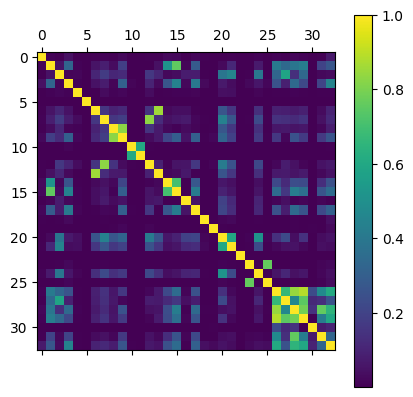

In [7]:
# Use this to get simplified correlation matrix 
new_corr =  df.iloc[:,:-1].corr().abs()
plt.matshow(new_corr)
plt.colorbar()
plt.show()

In [8]:
# Use this for standardize custom columns of dataframe
# NOTE: Remember to use the scaler with the test data to scale the data
def custom_col_standardize(df: pd.DataFrame, cols:list = 'all'):
    scalar = StandardScaler()
    scaled_data = df
    if cols == 'all':
        scaled_data.iloc[:,:-1] = pd.DataFrame(scalar.fit_transform(df.iloc[:,:-1])) 
    else:
        scaled_data.iloc[:,cols] = pd.DataFrame(scalar.fit_transform(df.iloc[:,cols])) 
    return scalar, scaled_data

In [9]:
sub_df = df     # use .sample(n) to get random n row from data frame to create sub_data
sub_df = sub_df[~sub_df.isin([np.nan, np.inf, -np.inf]).any(1)] # remove nan, inf, -inf value
X = sub_df.iloc[:,:-1].to_numpy()
Y = sub_df.iloc[:,-1].to_numpy()

C:\Users\Gray\AppData\Local\Temp\ipykernel_11884\3363250175.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  sub_df = sub_df[~sub_df.isin([np.nan, np.inf, -np.inf]).any(1)] # remove nan, inf, -inf value


In [10]:
def convert_label_to_class_label(Y :np.ndarray):
    Y_class = []
    c = {'DDoS-ICMP_Flood': 'DDos', 'DDoS-RSTFINFlood': 'DDos', 'DDoS-SYN_Flood': 'DDos', 'DDoS-SynonymousIP_Flood': 'DDos', 'DDoS-UDP_Flood': 'DDos', 'DDoS-PSHACK_Flood': 'DDos', 'DDoS-UDP_Fragmentation': 'DDos', 'DDoS-TCP_Flood': 'DDos', 'DDoS-ICMP_Fragmentation': 'DDos', 'DDoS-HTTP_Flood': 'DDos', 'DDoS-ACK_Fragmentation': 'DDos', 'DDoS-SlowLoris': 'DDos', 'DoS-UDP_Flood': 'Dos', 'DoS-TCP_Flood': 'Dos', 'DoS-SYN_Flood': 'Dos', 'DoS-HTTP_Flood': 'Dos', 'Recon-HostDiscovery': 'Recon', 'Recon-PortScan': 'Recon', 'Recon-OSScan': 'Recon', 'Recon-PingSweep': 'Recon', 'VulnerabilityScan': 'Recon', 'Uploading_Attack': 'Recon', 'SqlInjection': 'Web-based', 'CommandInjection': 'Web-based', 'Backdoor_Malware': 'Web-based', 'XSS': 'Web-based', 'MITM-ArpSpoofing': 'Spoofing', 'DNS_Spoofing': 'Spoofing', 'BrowserHijacking': 'Spoofing', 'DictionaryBruteForce': 'Bruteforce', 'Mirai-greeth_flood': 'Mirai', 'Mirai-udpplain': 'Mirai', 'Mirai-greip_flood': 'Mirai', 'BenignTraffic': 'Benign'}
    for i in Y:
        Y_class.append(c[i])
    return np.array(Y_class)


Y_class = convert_label_to_class_label(Y)

In [11]:
# This data for training detailed network attack 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25, random_state=random.randint(1,999)) #default was 0.2



print(X_train.shape,X_test.shape)

(351675, 33) (87919, 33)


In [11]:
# This data for training network attack by category
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X,Y_class,test_size=0.2, random_state=random.randint(1,999))

print(X_train_class.shape, X_test_class.shape)

(3779057, 33) (944765, 33)


TRAINING ROOM

In [23]:
#SGDC Classifier
from sklearn.linear_model import SGDClassifier
SGDC_clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3,n_jobs=-5))
SGDC_clf.fit(X_train_class,Y_train_class)
save_model('SGDC_class.pkl',SGDC_clf)


In [13]:
# Create model using SVM to classify specific attacks
# Use n_components='mle' to auto guess the dimension else speficy the dimension with int.

SVM_class_clf = make_pipeline(StandardScaler(),PCA(n_components='mle'), SVC(cache_size=2000))
SVM_class_clf.fit(X_train_class, Y_train_class)               # run in O(n^2), 400000 rows ~ 41mins training

save_model('SVM_class.pkl', SVM_class_clf)

In [ ]:
RF_clf = RandomForestClassifier()
RF_clf.fit(X_train,Y_train)
save_model('RF.pkl', RF_clf)

In [21]:
#8-Class Classifier
RF_clf = RandomForestClassifier(n_estimators= 8, max_leaf_nodes = 100, n_jobs=-1)
RF_clf.fit(X_train_class,Y_train_class)


RandomForestClassifier(max_leaf_nodes=100, n_estimators=8, n_jobs=-1)

In [15]:
save_model('RF.pkl', RF_clf)

TESTING ROOM

In [12]:

#8-Class test SVM Classifier
SVM_Y_predict_class = SVM_class_clf.predict(X_test_class)
print("SVM class model accuracy:", metrics.accuracy_score(Y_test_class, SVM_Y_predict_class))


In [14]:
#All-Class test Random Forest

RF_Y_predict = RF_clf.predict(X_test)
print("Random forest model accuracy:", metrics.accuracy_score(Y_test, RF_Y_predict))


Random forest model accuracy: 0.9923793491736712


In [22]:
#8-Class test Random Forest
RF_Y_predict = RF_clf.predict(X_test_class)
print("Random forest model accuracy:", metrics.accuracy_score(Y_test_class, RF_Y_predict))

Random forest model accuracy: 0.9909596566341895


In [24]:
#8-Class test SGDC Classifier
SGDC_Y_predict = SGDC_clf.predict(X_test_class)
print("SGDC model accuracy: ",metrics.accuracy_score(Y_test_class,SGDC_Y_predict))


SGDC model accuracy:  0.8151752022989844


In [ ]:
# Test on all other data


df2 = pd.concat([pd.read_csv(data_path+f'part-{x:05d}-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv') if x != 113 else pd.DataFrame() for x in range(169)])
print(df2.shape)

In [26]:
df2.drop(single_value_cols,axis=1, inplace=True)
df2.drop(high_corr_cols,axis=1, inplace=True) 
X_future_test = df2.iloc[:,:-1].to_numpy()

Y_future_test = df2.iloc[:,-1].to_numpy()
Y_future_test_class = convert_label_to_class_label(Y_future_test)

# Use any model here


In [ ]:
# Check accuracy here
